# Holistic Face Processing in Early Childhood

This is the code that creates the figures in the manuscript and runs the Factor Analysis relating children's accuracy on a composite face effect task to COVID-19 variables. Repeated-measures ANOVAs are run in R, but the code that sets up the csv files to run this is located here. 

**Table of Contents** 
- [Experiment 1: Upright Faces](#expt1)  

    - [Main analyses](#expt1_main)    
    - [COVID variables](#expt1_covid)     

- [Experiment 2: Inverted Faces](#expt2)    

    - [Main analyses](#expt2_main)    
    - [Comparing across experiments](#expt2_compare)   

In [1]:
# First import stuff
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, gls, mixedlm
from statsmodels.stats.anova import AnovaRM

from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

%matplotlib inline

In [2]:
# checks if string is nan
def string_nan(string):
    return string != string

# calculate p-values from a data frame correlation matrix 
def calculate_pvalues(df):
    df = df._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = stats.pearsonr(df[r], df[c])[1]
    return pvalues

# What are the conditions we are using, and what is their colors?
base_conditions=['misaligned_same','aligned_same','misaligned_different','aligned_different']
colors=['mediumseagreen','navy','mediumvioletred','darkred']

In [3]:
# Where is the data stored? 
exp1_data_dir='../Expt1/'
exp2_data_dir='../Expt2/'

## Experiment 1: Upright Faces <a id="expt1"> 

In [4]:
# Load in the file that tells us who the subjects are 
sub_data_dict=pd.read_csv('../Holistic_Face_Subject_Data.csv')
sub_data_dict.head()

,Experiment,child__hashed_id,child__age_rounded,child__gender
0,Expt1_Cohort1,UX6XX6,1800,m
1,Expt1_Cohort1,ZFEcFW,1530,f
2,Expt1_Cohort1,FMNR4U,1680,f
3,Expt1_Cohort1,QWFWAQ,2520,f
4,Expt1_Cohort1,PHM3KT,2130,f


In [5]:
# preset lists
subject_names=[]
subject_ages=[]
subject_genders=[]
cohorts=[]
subject_same_choices=[]

# preset dictionaries for RTs and accuracies
accuracy_data_dict={}
RT_data_dict={}

# do you want to restrict the RT range? 
restrict_rt=1

# Cycle through the rows
for row in range(len(sub_data_dict)):
    
    # get the sub name
    sub_name=sub_data_dict.child__hashed_id[row]
    
    if 'Expt1' in sub_data_dict.Experiment[row]:

       # get the subjects' data! 
        sub_trial_data=pd.read_csv(exp1_data_dir+sub_name+'.csv')
            
        # count the test trials
        test_trial_names=[i for i in np.unique(sub_trial_data.trials) if 'test-trial' in i]

        # drop the subject if they didn't finish the task
        if len(test_trial_names)<=35:
            print('dropping subject %s' % sub_name)
 
        else:
            # append age and gender
            subject_names.append(sub_name)
            subject_ages.append(sub_data_dict.child__age_rounded[row]/365) # put it in years
            subject_genders.append(sub_data_dict.child__gender[row])
            cohorts.append(sub_data_dict.Experiment[row])
            
            # get response time bounds within subject
            lower_bound_rt=np.nanmean(sub_trial_data.durations)-np.nanstd(sub_trial_data.durations)*2
            upper_bound_rt=np.nanmean(sub_trial_data.durations)+np.nanstd(sub_trial_data.durations)*2
            
            # how often did the child choose "same"
            percent_same = sum(sub_trial_data.choices=='same')/(sum(sub_trial_data.choices=='same')+sum(sub_trial_data.choices=='different'))
            subject_same_choices.append(percent_same)
            
            # cycle through the task conditions
            for c, cond in enumerate(base_conditions):
                
                if restrict_rt==1:
                    # figure out which trial durations are in the range we care about
                    durations=sub_trial_data.durations[sub_trial_data.conditions==cond]
                    
                    # mask
                    mask=np.array((durations>lower_bound_rt)*(durations<upper_bound_rt))

                    # what percent accurate was the kid?
                    percentage=np.nansum(sub_trial_data.accuracies[sub_trial_data.conditions==cond][mask])/sum(~string_nan(sub_trial_data.accuracies[sub_trial_data.conditions==cond][mask]))

                    # what is there average looking time?
                    looking_time=np.nanmean(sub_trial_data.durations[sub_trial_data.conditions==cond][mask])
                    
                else:
                    # what percent accurate was the kid?
                    percentage=np.nansum(sub_trial_data.accuracies[sub_trial_data.conditions==cond])/sum(~string_nan(sub_trial_data.accuracies[sub_trial_data.conditions==cond]))

                    # what is there average looking time?
                    looking_time=np.nanmean(sub_trial_data.durations[sub_trial_data.conditions==cond])

                # append the data
                if cond in accuracy_data_dict:
                    accuracy_data_dict[cond].append(percentage)
                else:
                    accuracy_data_dict[cond]=[percentage]

                # append the data
                if cond in RT_data_dict:
                    RT_data_dict[cond].append(looking_time)
                else:
                    RT_data_dict[cond]=[looking_time]


dropping subject 63dRcX
dropping subject GENZTP
dropping subject cFc63B
dropping subject ER3NYC


Average percent same choice: 0.5934153565732514
Number of kids always saying same: 2
Number of kids always saying different: 0


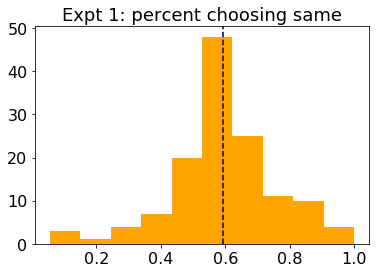

In [6]:
plt.hist(subject_same_choices,color='orange')
plt.title('Expt 1: percent choosing same', fontsize=18)
plt.axvline(np.nanmean(subject_same_choices),linestyle='dashed',color='black')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
print('Average percent same choice:',np.nanmean(subject_same_choices))
print('Number of kids always saying same:',sum(np.array(subject_same_choices)==1))
print('Number of kids always saying different:',sum(np.array(subject_same_choices)==0))

133


Text(0.5, 1.0, '5.394 years (4.027 -- 6.986)')

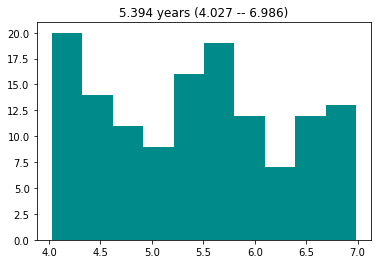

In [7]:
# How old are the kiddos?
plt.hist(subject_ages,color='darkcyan')
print(len(subject_ages))
plt.title('%0.3f years (%0.3f -- %0.3f)' %(np.nanmean(subject_ages),
                                           np.nanmin(subject_ages),np.nanmax(subject_ages)))

N total: 133
N non-males: 63
N males: 70


Text(0.5, 1.0, 'N non-males: 63; N males: 70')

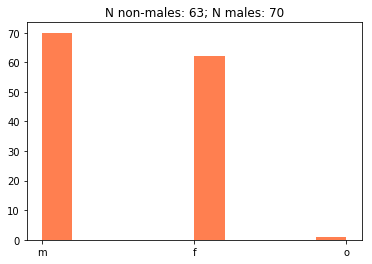

In [8]:
# What about gender?
print('N total:',len(subject_genders))
plt.hist(subject_genders,color='coral')
print('N non-males:',sum(np.array(subject_genders)!='m'))
print('N males:',sum(np.array(subject_genders)=='m'))

plt.title('N non-males: %d; N males: %d' % (sum(np.array(subject_genders)!='m'),
                                          sum(np.array(subject_genders)=='m')))

### Main analyses <a id="expt1_main"> 

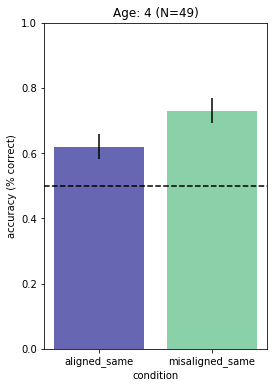

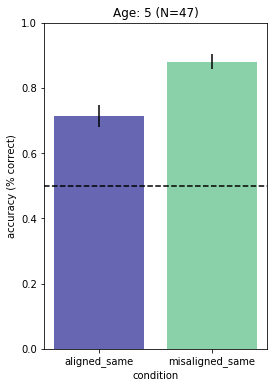

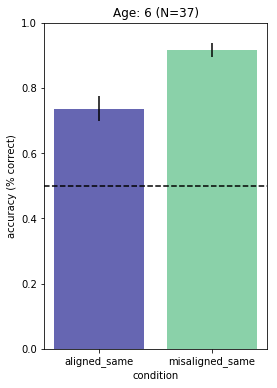

In [9]:
## Plot the main results!! 
## Same condition
reorganized_data_dict_keys=['aligned_same','misaligned_same']
reorganized_colors=['navy','mediumseagreen']

for a, age in enumerate(np.arange(4,7)):   
    
    fig=plt.figure(figsize=(4,6))    
    for c, cond in enumerate(reorganized_data_dict_keys):
        age_ids=np.floor(subject_ages)==age
        plt.bar(c,np.nanmean(np.array(accuracy_data_dict[cond])[age_ids]),color=reorganized_colors[c],alpha=0.6)
        plt.errorbar(c,np.nanmean(np.array(accuracy_data_dict[cond])[age_ids]),
                     stats.sem(np.array(accuracy_data_dict[cond])[age_ids],nan_policy='omit'),color='black')

        
    plt.title('Age: %d (N=%d)' %(age,len(np.array(accuracy_data_dict[cond])[age_ids])))
    plt.xticks(np.arange(len(reorganized_data_dict_keys)),reorganized_data_dict_keys)
    plt.ylabel('accuracy (% correct)')
    plt.xlabel('condition')
    plt.axhline(0.5,color='k',linestyle='--')
    plt.ylim(0,1)
    
    fig.savefig('%s_accuracy_main_results.svg' %age)

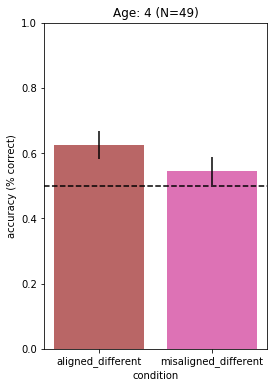

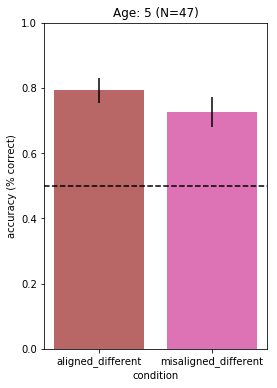

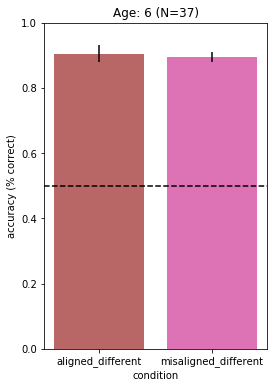

In [10]:
## Different condition
reorganized_data_dict_keys=['aligned_different','misaligned_different']
reorganized_colors=['darkred','mediumvioletred']

for a, age in enumerate(np.arange(4,7)):   
    
    fig=plt.figure(figsize=(4,6))    
    for c, cond in enumerate(reorganized_data_dict_keys):
        age_ids=np.floor(subject_ages)==age
        plt.bar(c,np.nanmean(np.array(accuracy_data_dict[cond])[age_ids]),color=reorganized_colors[c],alpha=0.6)
        plt.errorbar(c,np.nanmean(np.array(accuracy_data_dict[cond])[age_ids]),
                     stats.sem(np.array(accuracy_data_dict[cond])[age_ids],nan_policy='omit'),color='black')

    plt.title('Age: %d (N=%d)' %(age,len(np.array(accuracy_data_dict[cond])[age_ids])))
    plt.xticks(np.arange(len(reorganized_data_dict_keys)),reorganized_data_dict_keys)
    plt.ylabel('accuracy (% correct)')
    plt.xlabel('condition')
    plt.axhline(0.5,color='k',linestyle='--')
    plt.ylim(0,1)
    
    fig.savefig('%s_accuracy_different_results.svg' %age)

In [11]:
## Finally reformat data so we can run RM-ANOVAs in R 
# RT data
time_screen=[]
alignment=[]
condition=[]
sub_ids=[]
ages=[]
gender=[]
for cond in accuracy_data_dict:
    
    time_screen.extend(RT_data_dict[cond])
    alignment.extend([cond.split('_')[0]]*len(RT_data_dict[cond]))
    condition.extend([cond.split('_')[1]]*len(RT_data_dict[cond]))
    sub_ids.extend(subject_names)
    ages.extend(subject_ages)
    gender.extend(subject_genders)
    
rt_data_df=pd.DataFrame({'alignment':alignment,'condition':condition,
                         'time_screen':time_screen,
                         'sub':sub_ids,'age':ages,'gender':gender})

rt_data_df.to_csv('rt_data_dict_cohorts_1_2.csv')

# Accuracy
accuracies=[]
alignment=[]
condition=[]
sub_ids=[]
ages=[]
gender=[]
for cond in accuracy_data_dict:
    accuracies.extend(accuracy_data_dict[cond])
    alignment.extend([cond.split('_')[0]]*len(accuracy_data_dict[cond]))
    condition.extend([cond.split('_')[1]]*len(accuracy_data_dict[cond]))
    sub_ids.extend(subject_names)
    ages.extend(subject_ages)
    gender.extend(subject_genders)
    
accuracy_data_df=pd.DataFrame({'alignment':alignment,'condition':condition,
                               'accuracy':accuracies,
                               'sub':sub_ids,'age':ages,'gender':gender})

accuracy_data_df.to_csv('accuracy_data_dict_cohorts_1_2.csv')

### COVID analyses <a id="expt1_covid"> 

In [12]:
# load the dictionary
covid_dict_all_answers = pd.read_csv('../Holistic_Face_COVID_answers.csv',index_col=0)

# sort to be in the same order as the accuracy scores
reordered_indexs=[np.where(covid_dict_all_answers.subject_name==i)[0][0] 
                  for i in subject_names]
covid_dict_all_answers=covid_dict_all_answers.loc[reordered_indexs]
covid_dict_all_answers=covid_dict_all_answers.reset_index(drop=True)

# let's check! 
covid_dict_all_answers.head()

,impression,daycare_past,daycare_num_past,mandates_past,community_past,household_past,daycare_current,daycare_num_current,mandates_current,community_current,household_current,subject_name
0,I can tell people apart even if they’re wearin...,Yes,NaN,"No statewide mask mandate, but masks are stron...",Daily,Never,No,NaN,"No statewide mask mandate, but masks are stron...",Several times a week,Once every two weeks,UX6XX6
1,"Sometimes, I can’t tell people apart when they...",Sometimes,NaN,Statewide mask mandate in public settings for ...,Daily,Daily,No,NaN,"No statewide mask mandate, but masks are stron...",Daily,Daily,ZFEcFW
2,I can tell people apart even if they’re wearin...,Yes,NaN,Statewide mask mandate in public settings for ...,Never,Very rarely,No,NaN,No statewide or local mask mandate,Several times a week,Several times a week,FMNR4U
3,"Sometimes, I can’t tell people apart when they...",No,NaN,Statewide mask mandate in public settings for ...,Several times a week,Daily,No,NaN,"No statewide mask mandate, but masks are stron...",Daily,Daily,QWFWAQ
4,I can tell people apart even if they’re wearin...,No,NaN,Statewide mask mandate in public settings for ...,Several times a week,Daily,Yes,NaN,Statewide mask mandate in public settings for ...,Daily,Daily,PHM3KT


In [13]:
### First we need to reorganize/recode the COVID data

## 1. Face perception
# nan = no response, 0 = no trouble with masks, 1 = trouble with masks 
face_perceive=[]
for sub_response in covid_dict_all_answers['impression']:
    if string_nan(sub_response):
        face_perceive.append(np.nan)
    else:
        face_perceive.append(int('I can tell' in sub_response))
        
## 2. Day Care Past and 3. Day Care Current
recode_dict_daycare=dict({'Yes':2,'Sometimes':1,'No':0,'Prefer not to answer':np.nan})

daycare_past=[]
for sub_response in covid_dict_all_answers['daycare_past']:
    if string_nan(sub_response):
        daycare_past.append(np.nan)
    else:
        daycare_past.append(recode_dict_daycare[sub_response])
        
daycare_current=[]
for sub_response in covid_dict_all_answers['daycare_current']:
    if string_nan(sub_response):
        daycare_current.append(np.nan)
    else:
        daycare_current.append(recode_dict_daycare[sub_response])
        
## 4. Day Care Continuous Past and 5. Day Care Continuous Current
daycare_num_past=[]
for s in range(len(covid_dict_all_answers['daycare_num_past'])):
    
    sub_response=covid_dict_all_answers['daycare_num_past'][s]
    daycare_yesno=covid_dict_all_answers['daycare_past'][s]
    
    # if they didn't give a numerical answer but said no, recode to 0
    if string_nan(sub_response) and daycare_yesno=='No': 
        daycare_num_past.append(0)
    
    # if they didn't give a numerical answer but said yes or sometimes, keep as nan
    elif string_nan(sub_response) and daycare_yesno!='No':
        daycare_num_past.append(np.nan)
    else:
        daycare_num_past.append(np.int(sub_response))

daycare_num_current=[]
for s in range(len(covid_dict_all_answers['daycare_num_current'])):
    
    sub_response=covid_dict_all_answers['daycare_num_current'][s]
    daycare_yesno=covid_dict_all_answers['daycare_current'][s]
    
    # if they didn't give a numerical answer but said no, recode to 0
    if string_nan(sub_response) and daycare_yesno=='No': 
        daycare_num_current.append(0)
    
    # if they didn't give a numerical answer but said yes or sometimes, keep as nan
    elif string_nan(sub_response) and daycare_yesno!='No':
        daycare_num_current.append(np.nan)
    else:
        daycare_num_current.append(np.int(sub_response))
        
## 6. Mask Mandates Past and 7. Mask Mandates Present
recode_dict_mandate=({'No statewide or local mask mandate':0,
                     'No statewide mask mandate, but masks are strongly recommended in your city or county':1,
                     'No statewide mask mandate, but local mask requirement in your city or county':2,
                     'Statewide mask mandate in public settings for certain individuals only (e.g., barbers, restaurant employees, school employees and students) or inside buildings':3,
                     'Statewide mask mandate in public settings for all adults and older children':4,
                     'Statewide mask mandate in public settings for all individuals over age 2':5
                     })
mandates_past=[]
for sub_response in covid_dict_all_answers['mandates_past']:
    if string_nan(sub_response):
        mandates_past.append(np.nan)
    else:
        mandates_past.append(recode_dict_mandate[sub_response])
        
mandates_current=[]
for sub_response in covid_dict_all_answers['mandates_current']:
    if string_nan(sub_response):
        mandates_current.append(np.nan)
    else:
        mandates_current.append(recode_dict_mandate[sub_response])
        
        
## 8. Community Masking Past and 9. Community Masking Present  
recode_dict_masking=({'Prefer not to answer':np.nan,
                     'Never':0,
                     'Very rarely':1,
                     'Once every two weeks':2,
                     'Once a week':3,
                     'Several times a week':4,
                     'Daily':5
                     })
community_past=[]
for sub_response in covid_dict_all_answers['community_past']:
    if string_nan(sub_response):
        community_past.append(np.nan)
    else:
        community_past.append(recode_dict_masking[sub_response])

community_current=[]
for sub_response in covid_dict_all_answers['community_current']:
    if string_nan(sub_response):
        community_current.append(np.nan)
    else:
        community_current.append(recode_dict_masking[sub_response])

## 10. Family Masking Past and 11. Family Masking Present 
household_past=[]
for sub_response in covid_dict_all_answers['household_past']:
    if string_nan(sub_response):
        household_past.append(np.nan)
    else:
        household_past.append(recode_dict_masking[sub_response])

household_current=[]
for sub_response in covid_dict_all_answers['household_current']:
    if string_nan(sub_response):
        household_current.append(np.nan)
    else:
        household_current.append(recode_dict_masking[sub_response])        
        

In [14]:
# Create a MASSIVE new dataframe with all of this information
covid_predict_df=pd.DataFrame({'accuracy_aligned_same':accuracy_data_dict['aligned_same'],
                               'accuracy_misaligned_same':accuracy_data_dict['misaligned_same'],
                               'accuracy_aligned_different':accuracy_data_dict['aligned_different'],
                               'accuracy_misaligned_different':accuracy_data_dict['misaligned_different'],
                               'holistic_difference':np.array(accuracy_data_dict['misaligned_same']) - np.array(accuracy_data_dict['aligned_same']),
                               'other_difference':np.array(accuracy_data_dict['misaligned_different']) - np.array(accuracy_data_dict['aligned_different']),
                               'rt_aligned_same':RT_data_dict['aligned_same'],
                               'rt_difference':np.array(RT_data_dict['misaligned_same']) - np.array(RT_data_dict['aligned_same']),
                               'ages':subject_ages, 'gender':subject_genders,
                               'names':subject_names,
                              'face_perceive':face_perceive, 
                               'daycare_past':daycare_past,
                              'daycare_num_past':daycare_num_past, # delete the ones we know we didn't collect all of 
                               'daycare_current':daycare_current,
                              'daycare_num_current':daycare_num_current, # delete the ones we know we didn't collect all of 
                               'mandates_past':mandates_past,
                              'mandates_current':mandates_current,'community_past':community_past,
                              'community_current':community_current,'household_past':household_past,
                              'household_current':household_current})
covid_predict_df.head()

,accuracy_aligned_same,accuracy_misaligned_same,accuracy_aligned_different,accuracy_misaligned_different,holistic_difference,other_difference,rt_aligned_same,rt_difference,ages,gender,...,daycare_past,daycare_num_past,daycare_current,daycare_num_current,mandates_past,mandates_current,community_past,community_current,household_past,household_current
0,0.818182,0.416667,0.333333,0.666667,-0.401515,0.333333,3.718182,0.556818,4.931507,m,...,2.0,NaN,0.0,0.0,1.0,1.0,5.0,4.0,0.0,2.0
1,0.818182,1.000000,1.000000,1.000000,0.181818,0.000000,2.543636,-0.252727,4.191781,f,...,1.0,NaN,0.0,0.0,5.0,1.0,5.0,5.0,5.0,5.0
2,0.916667,1.000000,0.666667,0.333333,0.083333,-0.333333,1.691667,0.978333,4.602740,f,...,2.0,NaN,0.0,0.0,5.0,0.0,0.0,4.0,1.0,4.0
3,0.888889,1.000000,1.000000,0.833333,0.111111,-0.166667,0.588889,-0.088889,6.904110,f,...,0.0,0.0,0.0,0.0,5.0,1.0,4.0,5.0,5.0,5.0
4,0.600000,0.916667,1.000000,1.000000,0.316667,0.000000,7.770000,-1.536667,5.835616,f,...,0.0,0.0,2.0,NaN,5.0,3.0,4.0,5.0,5.0,5.0


In [15]:
# Create a new dataframe with just the COVID variables and ignoring subjects with incomplete questionnaire data
covid_demos=covid_predict_df.drop(columns=['accuracy_aligned_same','accuracy_misaligned_same',
                                           'accuracy_aligned_different','accuracy_misaligned_different',
                                           'holistic_difference','other_difference',
                                           'rt_aligned_same','rt_difference',
                                           'ages','gender','names'])
covid_demos_dropped_na=covid_demos.dropna(axis=0)
predict_dropped_na=covid_predict_df.dropna(axis=0)

covid_demos_dropped_na.shape

(96, 11)

In [16]:
# Tell us the correlation values
matrix = covid_demos_dropped_na.corr().round(2)
matrix

,face_perceive,daycare_past,daycare_num_past,daycare_current,daycare_num_current,mandates_past,mandates_current,community_past,community_current,household_past,household_current
face_perceive,1.00,-0.10,-0.06,-0.13,-0.09,-0.02,-0.15,-0.08,-0.16,-0.11,-0.08
daycare_past,-0.10,1.00,0.79,0.36,0.46,0.12,0.31,0.37,0.31,0.22,0.25
daycare_num_past,-0.06,0.79,1.00,0.36,0.57,0.05,0.19,0.31,0.30,0.19,0.20
daycare_current,-0.13,0.36,0.36,1.00,0.76,0.17,0.47,-0.04,0.40,0.08,0.33
daycare_num_current,-0.09,0.46,0.57,0.76,1.00,0.06,0.39,0.10,0.38,0.08,0.29
mandates_past,-0.02,0.12,0.05,0.17,0.06,1.00,0.37,0.36,0.19,0.35,0.16
mandates_current,-0.15,0.31,0.19,0.47,0.39,0.37,1.00,0.16,0.26,0.11,0.21
community_past,-0.08,0.37,0.31,-0.04,0.10,0.36,0.16,1.00,0.48,0.47,0.29
community_current,-0.16,0.31,0.30,0.40,0.38,0.19,0.26,0.48,1.00,0.19,0.39
household_past,-0.11,0.22,0.19,0.08,0.08,0.35,0.11,0.47,0.19,1.00,0.62


In [17]:
calculate_pvalues(covid_demos_dropped_na)

,face_perceive,daycare_past,daycare_num_past,daycare_current,daycare_num_current,mandates_past,mandates_current,community_past,community_current,household_past,household_current
face_perceive,0,0.333528,0.582524,0.193208,0.359737,0.831963,0.15484,0.413722,0.11812,0.27164,0.451912
daycare_past,0.333528,0,1.26301e-21,0.000354815,2.94678e-06,0.232445,0.00247197,0.000225099,0.00248784,0.0330934,0.0154771
daycare_num_past,0.582524,1.26301e-21,0,0.00034854,1.68342e-09,0.641594,0.0619621,0.00213919,0.0033116,0.063249,0.052379
daycare_current,0.193208,0.000354815,0.00034854,0,3.19139e-19,0.10445,1.76422e-06,0.667794,4.77373e-05,0.450546,0.00108355
daycare_num_current,0.359737,2.94678e-06,1.68342e-09,3.19139e-19,0,0.560457,0.000101119,0.346696,0.000111584,0.424685,0.00451039
mandates_past,0.831963,0.232445,0.641594,0.10445,0.560457,0,0.00021136,0.000271891,0.0597623,0.000507498,0.111659
mandates_current,0.15484,0.00247197,0.0619621,1.76422e-06,0.000101119,0.00021136,0,0.115197,0.0117046,0.283859,0.0422201
community_past,0.413722,0.000225099,0.00213919,0.667794,0.346696,0.000271891,0.115197,0,6.40872e-07,1.32716e-06,0.00484797
community_current,0.11812,0.00248784,0.0033116,4.77373e-05,0.000111584,0.0597623,0.0117046,6.40872e-07,0,0.0602655,9.75275e-05
household_past,0.27164,0.0330934,0.063249,0.450546,0.424685,0.000507498,0.283859,1.32716e-06,0.0602655,0,1.89411e-11


In [18]:
### Now we need to check for the ability to run factor analysis 

# Bartlett Sphericity  Test
chi_square_value,p_value=calculate_bartlett_sphericity(covid_demos_dropped_na)
print('Bartlett Sphericity Test:',chi_square_value, p_value)
print('DF:',(covid_demos_dropped_na.shape[0]-1)*(covid_demos_dropped_na.shape[1]-1))

# KMO (Kaiser-Meyer-Olkin) Test
# (should be greater than 0.6)
kmo_all,kmo_model=calculate_kmo(covid_demos_dropped_na)
print('KMO Test:',kmo_model)


Bartlett Sphericity Test: 442.06364605690896 7.430610559903672e-62
DF: 950
KMO Test: 0.6534086530986165


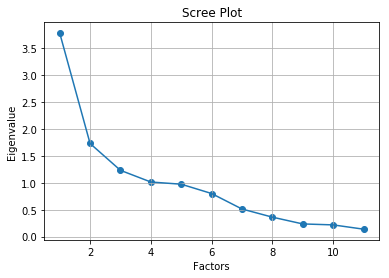

In [19]:
## Try out a Factor analysis with up to 9 components to determine the optimal eigenvalue number
fa = FactorAnalyzer(11, rotation=None)
fa.fit(covid_demos_dropped_na)

original_ev, common_ev = fa.get_eigenvalues()

# Scree plot to look at the eigenvalues
plt.scatter(range(1,covid_demos_dropped_na.shape[1]+1),original_ev,label='Original')
plt.plot(range(1,covid_demos_dropped_na.shape[1]+1),original_ev)

plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')

plt.grid()

                            0         1         2         3
face_perceive       -0.135541 -0.040113 -0.057334 -0.107334
daycare_past         0.250671  0.729042  0.101138  0.193261
daycare_num_past     0.211858  0.959485  0.076624  0.034843
daycare_current      0.941794  0.160845  0.107002 -0.024404
daycare_num_current  0.709027  0.422619  0.097467 -0.034474
mandates_past        0.182023 -0.054849  0.082932  0.586273
mandates_current     0.521175  0.073038  0.007700  0.336801
community_past      -0.096079  0.330181  0.252350  0.707059
community_current    0.336420  0.237005  0.235905  0.331630
household_past      -0.016941  0.114738  0.585111  0.406221
household_current    0.248336  0.075921  0.960291  0.095448

cumulative explained variance: 0.598159011599301


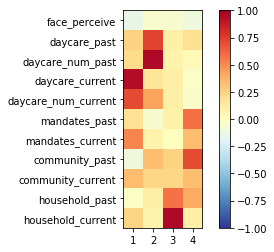

In [20]:
## Using the 4 factors, perform factor analysis
fa = FactorAnalyzer(4, rotation="varimax", method='minres', use_smc=True)
fa.fit(covid_demos_dropped_na)

fig=plt.figure()
plt.imshow(fa.loadings_,cmap='RdYlBu_r',vmin=-1,vmax=1)
_=plt.yticks(np.arange(covid_demos_dropped_na.corr().shape[0]),
             covid_demos_dropped_na.columns)
plt.xticks([0,1,2,3],[1,2,3,4])
plt.colorbar()

fig.savefig('covid_4-factor.svg')

# 4 Factor solution
# Factor 1 - highest for daycare current, daycare num current (Current Daycare)
# Factor 2 - highest for daycare past, daycare num past (Past Daycare)
# Factor 3 - highest for household current, househould past (Household Masking)
# Factor 4 - highest for cummunity past, mandates past (Past Community Adherence)

print(pd.DataFrame(fa.loadings_,
                   index=covid_demos_dropped_na.columns)) # Total 59% variance explained

print('\ncumulative explained variance:',fa.get_factor_variance()[2][-1])

# now get the factor values! 
fa_vals = fa.transform(covid_demos_dropped_na)

In [21]:
# change the way we are coding gender
predict_dropped_na['gender'][predict_dropped_na['gender']=='o']='non-m'
predict_dropped_na['gender'][predict_dropped_na['gender']=='f']='non-m'

In [22]:
covid_predict_df_fa=pd.DataFrame({'accuracy_aligned_same':predict_dropped_na['accuracy_aligned_same'],
                               'holistic_difference':predict_dropped_na['holistic_difference'],
                                  'rt_aligned_same':predict_dropped_na['rt_aligned_same'],
                               'rt_difference':predict_dropped_na['rt_difference'],
                              'ages':predict_dropped_na['ages'], 'gender':predict_dropped_na['gender'],
                            'ages_grouped':np.floor(predict_dropped_na['ages']),
                              'FA1':fa_vals[:,0], 'FA2':fa_vals[:,1],
                                 'FA3':fa_vals[:,2], 'FA4':fa_vals[:,3]})
covid_predict_df_fa.head()

,accuracy_aligned_same,holistic_difference,rt_aligned_same,rt_difference,ages,gender,ages_grouped,FA1,FA2,FA3,FA4
3,0.888889,0.111111,0.588889,-0.088889,6.904110,non-m,6.0,-1.233372,-0.808787,1.102736,0.171682
5,0.750000,0.250000,6.775000,-2.982000,4.931507,m,4.0,-1.239082,-0.649207,0.229035,0.597773
7,1.000000,-0.083333,2.588889,-0.405556,4.767123,m,4.0,-1.117618,-0.700413,-0.565800,0.358423
9,0.916667,0.083333,4.266667,-1.986667,5.424658,non-m,5.0,-1.236663,-0.685204,0.260277,0.478186
14,0.416667,0.166667,5.950000,4.347500,4.191781,m,4.0,-0.786696,-0.700791,-2.508165,0.426267


In [23]:
## Run the analysis! 
covid_predict_df_fa=sm.add_constant(covid_predict_df_fa)
print(covid_predict_df_fa.shape)

# perform lin regress with demographics and FAs
lin_model_demo = ols('accuracy_aligned_same ~ FA1 + FA2 + FA3 + FA4 + ages_grouped + gender', 
                     data=covid_predict_df_fa).fit()
print(lin_model_demo.summary())

print('Adjusted R-Squared:',lin_model_demo.rsquared_adj)

(96, 12)
                              OLS Regression Results                             
Dep. Variable:     accuracy_aligned_same   R-squared:                       0.091
Model:                               OLS   Adj. R-squared:                  0.030
Method:                    Least Squares   F-statistic:                     1.482
Date:                   Tue, 28 Feb 2023   Prob (F-statistic):              0.193
Time:                           10:27:55   Log-Likelihood:               -0.57396
No. Observations:                     96   AIC:                             15.15
Df Residuals:                         89   BIC:                             33.10
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Int

In [24]:
## Run the analysis! 
lin_model_demo = ols('holistic_difference ~ FA1 + FA2 + FA3 + FA4 + ages_grouped + gender', 
                     data=covid_predict_df_fa).fit()
print(lin_model_demo.summary())
print('Adjusted R-Squared:',lin_model_demo.rsquared_adj)

                             OLS Regression Results                            
Dep. Variable:     holistic_difference   R-squared:                       0.048
Model:                             OLS   Adj. R-squared:                 -0.016
Method:                  Least Squares   F-statistic:                    0.7438
Date:                 Tue, 28 Feb 2023   Prob (F-statistic):              0.616
Time:                         10:27:55   Log-Likelihood:                 11.211
No. Observations:                   96   AIC:                            -8.423
Df Residuals:                       89   BIC:                             9.528
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0068      

In [25]:
## Run the analysis! 
covid_predict_df_fa=sm.add_constant(covid_predict_df_fa)

# perform lin regress with demographics and FAs
lin_model_demo = ols('rt_aligned_same ~ FA1 + FA2 + FA3 + FA4 + ages_grouped + gender', 
                     data=covid_predict_df_fa).fit()
print(lin_model_demo.summary())

print('Adjusted R-Squared:',lin_model_demo.rsquared_adj)

                            OLS Regression Results                            
Dep. Variable:        rt_aligned_same   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.048
Method:                 Least Squares   F-statistic:                    0.2809
Date:                Tue, 28 Feb 2023   Prob (F-statistic):              0.945
Time:                        10:27:55   Log-Likelihood:                -212.08
No. Observations:                  96   AIC:                             438.2
Df Residuals:                      89   BIC:                             456.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.0590      1.509     

In [26]:
## Run the analysis! 
covid_predict_df_fa=sm.add_constant(covid_predict_df_fa)

# perform lin regress with demographics and FAs
lin_model_demo = ols('rt_difference ~ FA1 + FA2 + FA3 + FA4 + ages_grouped + gender', 
                     data=covid_predict_df_fa).fit()
print(lin_model_demo.summary())

print('Adjusted R-Squared:',lin_model_demo.rsquared_adj)

                            OLS Regression Results                            
Dep. Variable:          rt_difference   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.077
Date:                Tue, 28 Feb 2023   Prob (F-statistic):              0.382
Time:                        10:27:55   Log-Likelihood:                -171.17
No. Observations:                  96   AIC:                             356.3
Df Residuals:                      89   BIC:                             374.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.1819      0.986     

## Experiment 2: Inverted Faces <a id="expt2"> 

In [27]:
# What are the conditions we are using?
base_conditions_expt2=['misaligned_inverted_same','aligned_inverted_same',
                 'misaligned_inverted_different','aligned_inverted_different']

In [28]:
restrict_rt=1 # restrict the RTs we are considering 

# preset lists
subject_names_expt2=[]
subject_cohort_expt2=[]
subject_ages_expt2=[]
subject_genders_expt2=[]
subject_same_choices_expt2=[]

# preset dictionaries for RTs and accuracies
accuracy_data_dict_expt2={}
RT_data_dict_expt2={}

# Cycle through the rows
for row in range(len(sub_data_dict)):
    
    # get the sub name
    sub_name=sub_data_dict.child__hashed_id[row]
    
    if 'Expt2' in sub_data_dict.Experiment[row] and isinstance(sub_name,str):

       # get the subjects' data! 
        sub_trial_data=pd.read_csv(exp2_data_dir+sub_name+'.csv')
            
        # count the test trials
        test_trial_names=[i for i in np.unique(sub_trial_data.trials) if 'test-trial' in i]

        # drop the subject if they didn't finish the task
        if len(test_trial_names)<=35:
            print('dropping subject %s' % sub_name)
 
        else:
            # append age and gender
            subject_names_expt2.append(sub_name)
            subject_ages_expt2.append(sub_data_dict.child__age_rounded[row]/365) # put it in years
            subject_genders_expt2.append(sub_data_dict.child__gender[row])
            subject_cohort_expt2.append(sub_data_dict.Experiment[row])
                  
            # get response time bounds within subject
            lower_bound_rt=np.nanmean(sub_trial_data.durations)-np.nanstd(sub_trial_data.durations)*2
            upper_bound_rt=np.nanmean(sub_trial_data.durations)+np.nanstd(sub_trial_data.durations)*2
            
            # how often did the child choose "same"
            percent_same = sum(sub_trial_data.choices=='same')/(sum(sub_trial_data.choices=='same')+sum(sub_trial_data.choices=='different'))
            subject_same_choices_expt2.append(percent_same)
            
            # cycle through the task conditions
            for c, cond in enumerate(base_conditions_expt2):

                if restrict_rt==1:
                    # figure out which trial durations are in the range we care about
                    durations=sub_trial_data.durations[sub_trial_data.conditions==cond]
                    
                    # mask
                    mask=np.array((durations>lower_bound_rt)*(durations<upper_bound_rt))

                    # what percent accurate was the kid?
                    percentage=np.nansum(sub_trial_data.accuracies[sub_trial_data.conditions==cond][mask])/sum(~string_nan(sub_trial_data.accuracies[sub_trial_data.conditions==cond][mask]))

                    # what is there average looking time?
                    looking_time=np.nanmean(sub_trial_data.durations[sub_trial_data.conditions==cond][mask])
                    
                else:
                    # what percent accurate was the kid?
                    percentage=np.nansum(sub_trial_data.accuracies[sub_trial_data.conditions==cond])/sum(~string_nan(sub_trial_data.accuracies[sub_trial_data.conditions==cond]))

                    # what is there average looking time?
                    looking_time=np.nanmean(sub_trial_data.durations[sub_trial_data.conditions==cond])

                # append the data
                if cond in accuracy_data_dict_expt2:
                    accuracy_data_dict_expt2[cond].append(percentage)
                else:
                    accuracy_data_dict_expt2[cond]=[percentage]

                # append the data
                if cond in RT_data_dict_expt2:
                    RT_data_dict_expt2[cond].append(looking_time)
                else:
                    RT_data_dict_expt2[cond]=[looking_time]


Average percent same choice: 0.6538461538461539
Number of kids always saying same: 0
Number of kids always saying different: 0


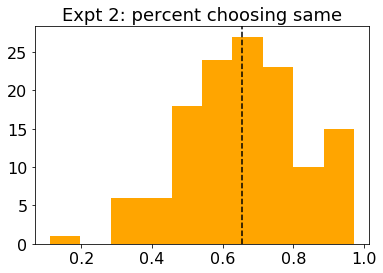

In [29]:
plt.hist(subject_same_choices_expt2,color='orange')
plt.title('Expt 2: percent choosing same', fontsize=18)
plt.axvline(np.nanmean(subject_same_choices_expt2),linestyle='dashed',color='black')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
print('Average percent same choice:',np.nanmean(subject_same_choices_expt2))
print('Number of kids always saying same:',sum(np.array(subject_same_choices_expt2)==1))
print('Number of kids always saying different:',sum(np.array(subject_same_choices_expt2)==0))

Text(0.5, 1.0, '5.360 years (4.027 -- 7.151)')

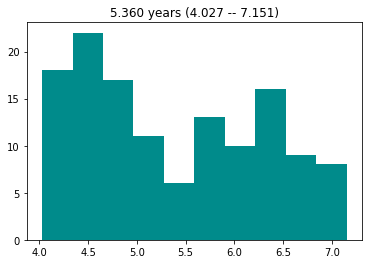

In [30]:
plt.hist(subject_ages_expt2,color='darkcyan')
plt.title('%0.3f years (%0.3f -- %0.3f)' %(np.nanmean(subject_ages_expt2),
                                           np.nanmin(subject_ages_expt2),
                                           np.nanmax(subject_ages_expt2)))

N non-males: 62
N males: 68


Text(0.5, 1.0, 'N non-males: 62; N males: 68')

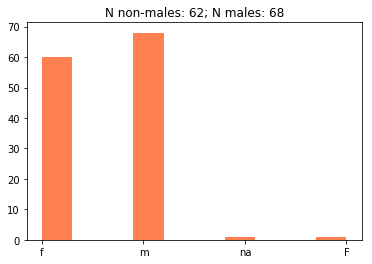

In [31]:
plt.hist(subject_genders_expt2,color='coral')
print('N non-males:',sum(np.array(subject_genders_expt2)!='m'))
print('N males:',sum(np.array(subject_genders_expt2)=='m'))

plt.title('N non-males: %d; N males: %d' % (sum(np.array(subject_genders_expt2)!='m'),
                                          sum(np.array(subject_genders_expt2)=='m')))

In [32]:
# Are the two experiments different in terms of demographics?
# First, gender
print('Percent non-male expt 1: %0.3f' % (sum(np.array(subject_genders)!='m')/len(subject_genders)))
print('Percent non-male expt 2: %0.3f' % (sum(np.array(subject_genders_expt2)!='m')/len(subject_genders_expt2)))
print('Binomial p = %0.3f\n' % stats.binom_test(x=sum(np.array(subject_genders_expt2)!='m'),
                                                n=len(subject_genders_expt2),
                 p=sum(np.array(subject_genders)!='m')/len(subject_genders)))

# Second, age
pval_diff=stats.ttest_ind(subject_ages,subject_ages_expt2)[1]
print('Mean age expt 1: %0.3f' %np.mean(subject_ages))
print('Mean age expt 2: %0.3f' %np.mean(subject_ages_expt2))
print('T-test p = %0.3f' %(pval_diff))

Percent non-male expt 1: 0.474
Percent non-male expt 2: 0.477
Binomial p = 1.000

Mean age expt 1: 5.394
Mean age expt 2: 5.360
T-test p = 0.759


### Main analyses <a id="expt2_main"> 

Age: 4 (N=57) - mean=4.476, sd=0.254, female=25
Age: 5 (N=32) - mean=5.463, sd=0.283, female=17
Age: 6 (N=41) - mean=6.507, sd=0.312, female=20


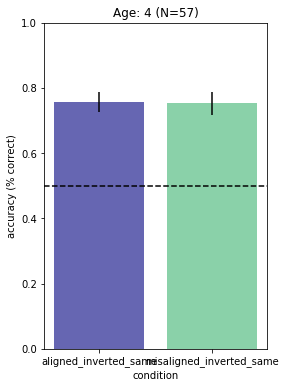

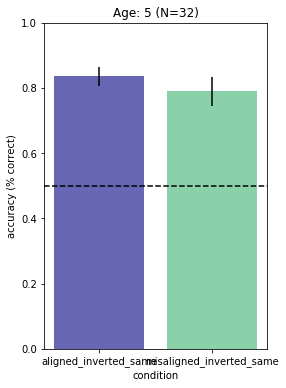

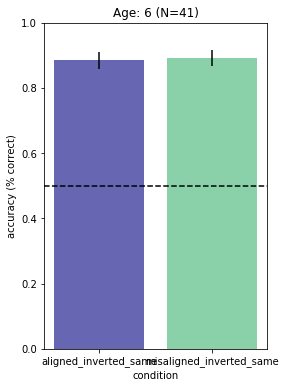

In [33]:
## Plot the main results!! 
## Same condition
reorganized_data_dict_keys=['aligned_inverted_same','misaligned_inverted_same']
reorganized_colors=['navy','mediumseagreen']

for a, age in enumerate(np.arange(4,7)):   
   
    fig=plt.figure(figsize=(4,6))    
    for c, cond in enumerate(reorganized_data_dict_keys):
        
        if age==6:
            age_ids=np.floor(subject_ages_expt2)>=age
        else:
            age_ids=np.floor(subject_ages_expt2)==age
        
        plt.bar(c,np.nanmean(np.array(accuracy_data_dict_expt2[cond])[age_ids]),
                color=reorganized_colors[c],alpha=0.6)
        plt.errorbar(c,np.nanmean(np.array(accuracy_data_dict_expt2[cond])[age_ids]),
                     stats.sem(np.array(accuracy_data_dict_expt2[cond])[age_ids],
                               nan_policy='omit'),color='black')

        
    print('Age: %d (N=%d) - mean=%0.3f, sd=%0.3f, female=%d' %(age,
                                                                  len(np.array(subject_ages_expt2)[age_ids]),
                                                                 np.nanmean(np.array(subject_ages_expt2)[age_ids]),
                                                                 np.nanstd(np.array(subject_ages_expt2)[age_ids]),
                                                                 sum(np.array(subject_genders_expt2)[age_ids]!='m')))
    plt.title('Age: %d (N=%d)' %(age,len(np.array(accuracy_data_dict_expt2[cond])[age_ids])))
    plt.xticks(np.arange(len(reorganized_data_dict_keys)),reorganized_data_dict_keys)
    plt.ylabel('accuracy (% correct)')
    plt.xlabel('condition')
    plt.axhline(0.5,color='k',linestyle='--')
    plt.ylim(0,1)
    
    fig.savefig('%s_accuracy_main_results_expt2.svg' %age)

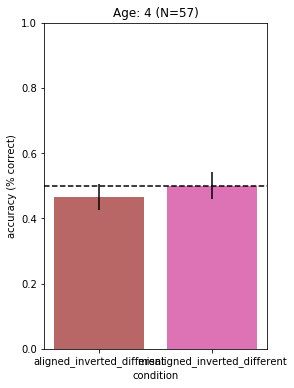

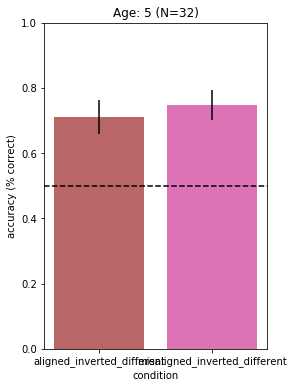

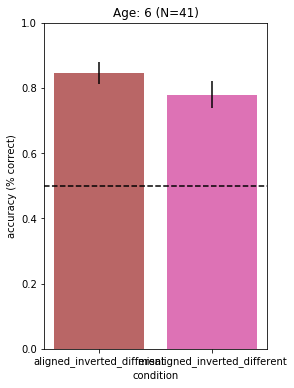

In [34]:
## Different condition
reorganized_data_dict_keys=['aligned_inverted_different','misaligned_inverted_different']
reorganized_colors=['darkred','mediumvioletred']

for a, age in enumerate(np.arange(4,7)):   
    
    fig=plt.figure(figsize=(4,6))    
    for c, cond in enumerate(reorganized_data_dict_keys):
        if age==6:
            age_ids=np.floor(subject_ages_expt2)>=age
        else:
            age_ids=np.floor(subject_ages_expt2)==age
        
        plt.bar(c,np.nanmean(np.array(accuracy_data_dict_expt2[cond])[age_ids]),
                color=reorganized_colors[c],alpha=0.6)
        plt.errorbar(c,np.nanmean(np.array(accuracy_data_dict_expt2[cond])[age_ids]),
                     stats.sem(np.array(accuracy_data_dict_expt2[cond])[age_ids],
                               nan_policy='omit'),color='black')

    plt.title('Age: %d (N=%d)' %(age,len(np.array(accuracy_data_dict_expt2[cond])[age_ids])))
    plt.xticks(np.arange(len(reorganized_data_dict_keys)),reorganized_data_dict_keys)
    plt.ylabel('accuracy (% correct)')
    plt.xlabel('condition')
    plt.axhline(0.5,color='k',linestyle='--')
    plt.ylim(0,1)
    
    fig.savefig('%s_accuracy_different_results_expt2.svg' %age)

In [35]:
## Finally reformat data so we can run RM-ANOVAs in R 
# RT data
time_screen=[]
alignment=[]
condition=[]
sub_ids=[]
ages=[]
gender=[]
cohort=[]
for cond in RT_data_dict_expt2:
    
    time_screen.extend(RT_data_dict_expt2[cond])
    alignment.extend([cond.split('_')[0]]*len(RT_data_dict_expt2[cond]))
    condition.extend([cond.split('_')[2]]*len(RT_data_dict_expt2[cond]))
    sub_ids.extend(subject_names_expt2)
    ages.extend(subject_ages_expt2)
    gender.extend(subject_genders_expt2)
    cohort.extend(subject_cohort_expt2)
    
rt_data_df_expt2=pd.DataFrame({'alignment':alignment,'condition':condition,
                         'time_screen':time_screen,
                         'sub':sub_ids,'age':ages,'gender':gender,'cohort':cohort})

rt_data_df_expt2.to_csv('rt_data_dict_part2.csv')

# Accuracy
accuracies=[]
alignment=[]
condition=[]
sub_ids=[]
ages=[]
gender=[]
cohort=[]
for cond in accuracy_data_dict_expt2:
    accuracies.extend(accuracy_data_dict_expt2[cond])
    alignment.extend([cond.split('_')[0]]*len(accuracy_data_dict_expt2[cond]))
    condition.extend([cond.split('_')[2]]*len(accuracy_data_dict_expt2[cond]))
    sub_ids.extend(subject_names_expt2)
    ages.extend(subject_ages_expt2)
    gender.extend(subject_genders_expt2)
    cohort.extend(subject_cohort_expt2)
    
accuracy_data_df_expt2=pd.DataFrame({'alignment':alignment,'condition':condition,
                               'accuracy':accuracies,
                               'sub':sub_ids,'age':ages,'gender':gender,'cohort':cohort})

accuracy_data_df_expt2.to_csv('accuracy_data_dict_part2.csv')

### Comparing experiments <a id="expt2_compare"> 

In [36]:
reorganized_data_dict_keys=['aligned_same','misaligned_same']
reorganized_colors=['navy','mediumseagreen']

In [37]:
## IDs of participants who did both experiments, in the correct order
part1_subject_names=np.array(['3W34dW', '2G2AL4', 'MX7YEJ', '4LVKMA', 'KKY3TT', 'FZLQ2Y',
       'NTYN3N', 'RNcVC3', 'dEEK22', 'JMTYZH', 'Uc5HAY', 'F4AJSB',
       'RJRCRR', 'WScYBT', '5cKP4G', '46QP6X', 'dHWQWK', '2TGKCT',
       'LA6RF5', 'CECNMS', 'JY6LQ2', 'VXA7XE', 'MR5U5N', 'K6FGHF',
       'TNSEWV', 'PB3BCS', 'ZRHCPK', 'G277c4', 'ZTYVTW', 'XV65MW',
       'RU4MYJ', 'FWYC7C', 'BcD7QG', '6RPUM7', 'R52TRD'])
part1_indexs=[np.where(np.array(subject_names)==i)[0][0] for i in part1_subject_names]

part2_subject_names=np.array(['QFZJCK', 'EASJMJ', 'GHVHK6', 'CAT4ZG', 'JT3dCQ', '5MPU6P',
       '3VTF4d', 'RBPFW2', 'JY3YHZ', '2XXKHX', 'ZLTdXJ', 'ZPTAAN',
       'NJdNH4', 'NGd6cH', '66KR2A', 'SNQL5Q', 'LZ4VF4', 'TMYEYX',
       'BVATJP', 'WJVWWU', '2RWWZ7', '4GHD47', 'D3FQFL', 'DCQcGU',
       'PRCGVE', 'CDJG6B', 'Z6A6HA', 'HU53KP', 'SQTVTK', 'WdYBcR',
       'JYcPYS', 'cULKQ4', '2WP74c', '637KXW', 'EFUU5P'])
part2_indexs=[np.where(np.array(subject_names_expt2)==i)[0][0] for i in part2_subject_names]

aligned_same
Upright=0.703, Inverted=0.824, 
diff=-0.120, tval=-2.644, pval=0.012, d=-0.490

misaligned_same
Upright=0.853, Inverted=0.854, 
diff=-0.001, tval=-0.030, pval=0.976, d=-0.007



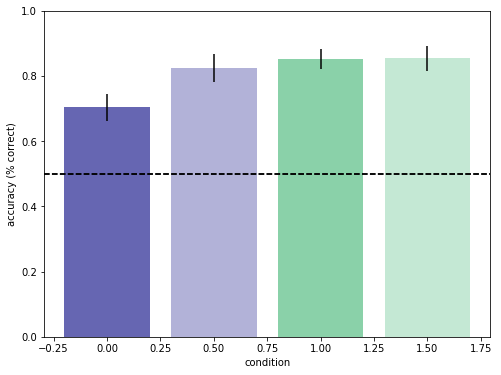

In [38]:
fig=plt.figure(figsize=(8,6))

for c, cond in enumerate(reorganized_data_dict_keys):
    
    # get the experiment 1 data, in the order we want
    part1_data=np.array(accuracy_data_dict[cond])[part1_indexs]
    
    # plot it 
    plt.bar(c,np.nanmean(part1_data),color=reorganized_colors[c],alpha=0.6,width=0.4)
    plt.errorbar(c,np.nanmean(part1_data),
                 stats.sem(part1_data,nan_policy='omit'),color='black')
    
    cond2="%s_%s_%s" %(cond.split('_')[0],'inverted',cond.split('_')[1])
    
    part2_data=np.array(accuracy_data_dict_expt2[cond2])[part2_indexs]
    
    plt.bar(c+0.5,np.nanmean(part2_data),color=reorganized_colors[c],alpha=0.3,width=0.4)
    plt.errorbar(c+0.5,np.nanmean(part2_data),
                 stats.sem(part2_data,nan_policy='omit'),color='black')
    
    # run a paired  t test
    tval, pval=stats.ttest_rel(part1_data,part2_data)
    
    # calculate the cohen's d 
    cohens_d = (np.mean(part1_data) - np.mean(part2_data)) / np.sqrt((np.std(part1_data, ddof=1) ** 2 + np.std(part2_data, ddof=1) ** 2) / 2.0)
    
    print(cond)
    print('Upright=%0.3f, Inverted=%0.3f, \ndiff=%0.3f, tval=%0.3f, pval=%0.3f, d=%0.3f\n' %(np.nanmean(part1_data),
                                            np.nanmean(part2_data),(np.nanmean(part1_data)-np.nanmean(part2_data)),
                                                 tval, pval, cohens_d))
    
    plt.ylabel('accuracy (% correct)')
    plt.xlabel('condition')
    plt.axhline(0.5,color='k',linestyle='--')
    plt.ylim(0,1)
    
    fig.savefig('exp1_exp2_same_trials.svg')